Using output directory: .
Using main data (Facial, Speech, ADL, ALSFRS): 'data_preprocessed_linguistic_features_filtered_metrics.csv'
Using translation dictionary: 'metric_and_task_names_to_display.json'

Loading translation dictionary from metric_and_task_names_to_display.json...
Error: Translation file not found at 'metric_and_task_names_to_display.json'. Translations will not be applied.

Loading data...
Loaded main data. Shape: (145, 207)

Filtering for patient sessions...
Filtered down to 75 patient sessions.

Identifying all feature column sets from filtered patient data...
Populating reverse translation map...
Reverse translation map populated with 137 entries.
Validated 54 facial feature columns.
Validated 20 speech feature columns.
Validated 59 linguistic feature columns.
Validated 4 ADL feature columns.

Preparing final patient data for correlation...
Ensuring columns are numeric (if not already)...
 0 columns converted to numeric (errors='coerce'). 143 already numeric.
Calcu

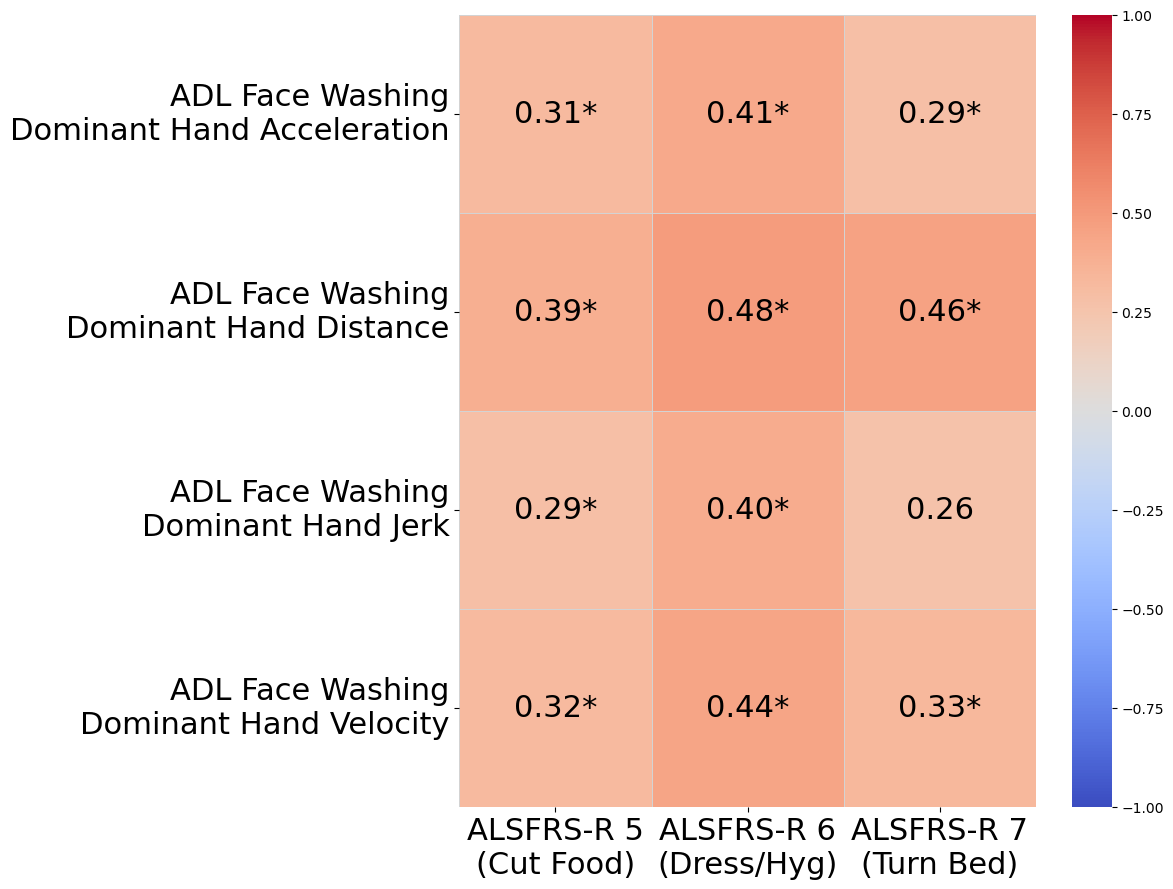

In [4]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
from scipy.stats import spearmanr # Using Spearman
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import sys
import os
import json # Added for JSON loading
from collections import defaultdict # Added for reverse mapping
import re
# improt re

# --- Suppress warnings ---
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)

# --- Configuration ---
# Output Directory
OUTPUT_DIR = "."
if not os.path.exists(OUTPUT_DIR): os.makedirs(OUTPUT_DIR)
print(f"Using output directory: {OUTPUT_DIR}")

# Input Files
PATH_MAIN_DATA = 'data_preprocessed_linguistic_features_filtered_metrics.csv'
PATH_TRANSLATION_JSON = 'metric_and_task_names_to_display.json'

print(f"Using main data (Facial, Speech, ADL, ALSFRS): '{PATH_MAIN_DATA}'")
print(f"Using translation dictionary: '{PATH_TRANSLATION_JSON}'")

COHORT_COL = 'demo_patient_flag' # From demographics data

# Define ALSFRS-R column names
ALSFRSR_Q1_COL = 'survey_response_scores_ALSFRSR_1'
ALSFRSR_Q2_COL = 'survey_response_scores_ALSFRSR_2'
ALSFRSR_Q3_COL = 'survey_response_scores_ALSFRSR_3'
ALSFRSR_Q5_1_COL = 'survey_response_scores_ALSFRSR_5_1'
ALSFRSR_Q6_COL = 'survey_response_scores_ALSFRSR_6'
ALSFRSR_Q7_COL = 'survey_response_scores_ALSFRSR_7'
ALSFRSR_BULBAR_COL_NAME = 'ALSFRS-R Bulbar' # Consistent naming

ALL_ALSFRSR_COLS_TO_LOAD = [
    ALSFRSR_Q1_COL, ALSFRSR_Q2_COL, ALSFRSR_Q3_COL,
    ALSFRSR_Q5_1_COL, ALSFRSR_Q6_COL, ALSFRSR_Q7_COL
]
ALSFRSR_TARGET_COLS = [ # Targets for correlation
    #ALSFRSR_Q1_COL, ALSFRSR_BULBAR_COL_NAME,
    ALSFRSR_Q5_1_COL, ALSFRSR_Q6_COL, ALSFRSR_Q7_COL
]
ALSFRSR_LABEL_MAP = { # Labels for heatmap columns
#    ALSFRSR_Q1_COL: 'ALSFRS-R 1 (Speech)',
#    ALSFRSR_BULBAR_COL_NAME: 'ALSFRS-R Bulbar',
    ALSFRSR_Q5_1_COL: 'ALSFRS-R 5\n(Cut Food)',
    ALSFRSR_Q6_COL: 'ALSFRS-R 6\n(Dress/Hyg)',
    ALSFRSR_Q7_COL: 'ALSFRS-R 7\n(Turn Bed)'
}

# --- Define prefixes for ALL feature types ---
FACIAL_PREFIX = 'facial_metrics_'
SPEECH_PREFIX = 'speech_metrics_'
LINGUISTIC_PREFIX = 'text_metrics_'
ADL_PREFIX = 'ADL' # Corrected prefix based on CSV header inspection

# --- Mapping from feature group name to prefix ---
# Used to add prefix column during aggregation
PREFIX_MAP = {
    "Facial": FACIAL_PREFIX,
    "Speech": SPEECH_PREFIX,
    "Linguistic": LINGUISTIC_PREFIX,
    "ADL": ADL_PREFIX
}

# --- Font colors for Y-AXIS heatmap labels ---  (Updated Purpose)
# Adjusted to match the actual prefixes used in the code
YAXIS_LABEL_COLORS = { # Renamed for clarity
    SPEECH_PREFIX: 'brown',
    FACIAL_PREFIX: 'darkcyan',
    LINGUISTIC_PREFIX: 'darkblue',
    ADL_PREFIX: 'black'
    # No cognitive metrics prefix defined, so removed from here
}
DEFAULT_YAXIS_COLOR = 'grey' # Color for labels whose group is unknown or mixed

# Heatmap Style Configuration
HEATMAP_CMAP = 'coolwarm'
HEATMAP_ANNOT_FMT = ".2f"
HEATMAP_CENTER = 0.0
SIGNIFICANCE_THRESHOLD = 0.05
MIN_PAIRS_THRESHOLD = 5 # Min pairs for pairwise correlation
ANNOTATION_COLOR = 'black' # --- NEW: Set annotation color to black ---

# --- Load Translation Dictionary ---
print(f"\nLoading translation dictionary from {PATH_TRANSLATION_JSON}...")
try:
    with open(PATH_TRANSLATION_JSON, 'r', encoding='utf-8') as f:
        translation_dict = json.load(f)
    print("Translation dictionary loaded successfully.")
    reverse_translation_map = defaultdict(list)
    # This map will be populated after data loading
except FileNotFoundError:
    print(f"Error: Translation file not found at '{PATH_TRANSLATION_JSON}'. Translations will not be applied.")
    translation_dict = {}
    reverse_translation_map = defaultdict(list)
except json.JSONDecodeError:
    print(f"Error: Could not decode JSON from '{PATH_TRANSLATION_JSON}'. Translations might be incorrect.")
    translation_dict = {}
    reverse_translation_map = defaultdict(list)
except Exception as e:
    print(f"An unexpected error occurred loading the translation file: {e}")
    translation_dict = {}
    reverse_translation_map = defaultdict(list)

# --- Functions ---

def clean_col_names(df):
    """Strips leading/trailing whitespace from DataFrame column names."""
    df.columns = df.columns.str.strip()
    return df

def clean_feature_list(df, cols):
    """Checks if columns exist and have any valid numeric data."""
    valid_cols = []
    for col in cols:
        if col in df.columns:
            numeric_series = pd.to_numeric(df[col], errors='coerce')
            if numeric_series.notna().any():
                valid_cols.append(col)
    return valid_cols

def calculate_correlations_pairwise_spearman(df, feature_cols, target_cols, min_pairs=3):
    """
    Calculates Spearman correlations (rho and p-value) using pairwise deletion.
    """
    results = []
    skipped_metrics_count = 0
    valid_pairs_calculated = 0

    for feature in feature_cols:
        if feature not in df.columns: continue
        feature_has_data = False

        for target in target_cols:
            if target not in df.columns: continue
            pair_data = df[[feature, target]].dropna() # Pairwise deletion

            if len(pair_data) < min_pairs: continue
            if pair_data[feature].nunique(dropna=True) < 2 or pair_data[target].nunique(dropna=True) < 2: continue

            try:
                corr, p_value = spearmanr(pair_data[feature], pair_data[target])
                if not np.isnan(corr) and not np.isnan(p_value):
                    results.append({
                        'Feature': feature,
                        'Target': target,
                        'Correlation (rho)': corr,
                        'P-value': p_value,
                        'N_pairs': len(pair_data)
                    })
                    feature_has_data = True
                    valid_pairs_calculated += 1
            except ValueError as ve:
                pass

        if not feature_has_data:
             skipped_metrics_count += 1

    if skipped_metrics_count > 0:
        print(f"Note: {skipped_metrics_count} metrics had insufficient data pairs (<{min_pairs}) or constant values for Spearman correlation with any target and were skipped.")

    print(f"Total valid Spearman correlation pairs calculated: {valid_pairs_calculated}")
    return pd.DataFrame(results)

def translate_label(text, conversion_dict):
    """Replaces parts of a label based on a key-value dictionary."""
    if not text:
        return text
    translated = text
    for key, value in conversion_dict.items():
        translated = translated.replace(key, value)
    return translated

# --- UPDATED AGGREGATED PLOTTING FUNCTION ---
def plot_aggregated_correlation_heatmap(
    combined_results_df,
    target_label_map,
    translation_dict,
    yaxis_label_colors, # Changed name
    orig_feature_to_prefix_map,
    reverse_translation_map_local, # Pass this specific map
    p_threshold=0.05
):
    """
    Generates ONE aggregated heatmap. Annotations are black.
    Y-axis labels are colored based on the original feature group.
    """
    if combined_results_df is None or combined_results_df.empty:
        print(f"\nNo correlation results found for any group. Skipping aggregated heatmap.")
        return

    print("\n--- Generating Aggregated Heatmap (Black Annotations, Colored Y-Labels) ---")

    # Filter for features with AT LEAST ONE significant correlation across ALL groups
    significant_results = combined_results_df[combined_results_df['P-value'] < p_threshold].copy()
    if significant_results.empty:
        print(f"\nNo significant Spearman correlations (p < {p_threshold}) found across all features. Skipping aggregated heatmap.")
        return

    significant_features = significant_results['Feature'].unique()
    print(f"\nFound {len(significant_features)} features across all groups with >= 1 significant Spearman correlation (p < {p_threshold}).")

    # Filter original combined results to only include these significant features (vs all targets)
    heatmap_data_filtered = combined_results_df[combined_results_df['Feature'].isin(significant_features)]

    # Add Translated Feature column
    heatmap_data_filtered['Translated Feature'] = heatmap_data_filtered['Feature'].map(
        lambda orig: translate_label(orig, translation_dict)
    )

    # Pivot for heatmap - Correlation Values (rho) - Use Translated Feature for index
    try:
        heatmap_pivot = heatmap_data_filtered.pivot_table(index='Translated Feature', columns='Target', values='Correlation (rho)', aggfunc='mean')
        heatmap_pivot = heatmap_pivot.reindex(columns=list(target_label_map.keys())) # Ensure target order
    except Exception as e:
        print(f"Error creating aggregated correlation pivot table: {e}. Skipping heatmap.")
        return

    # Pivot for heatmap - P-Values - Use Translated Feature for index
    try:
        pval_pivot = heatmap_data_filtered.pivot_table(index='Translated Feature', columns='Target', values='P-value', aggfunc='min')
        pval_pivot = pval_pivot.reindex(index=heatmap_pivot.index, columns=heatmap_pivot.columns)
    except Exception as e:
        print(f"Error creating aggregated p-value pivot table: {e}. Significance asterisks may be missing.")
        pval_pivot = pd.DataFrame(np.nan, index=heatmap_pivot.index, columns=heatmap_pivot.columns)

    # Apply labels to columns (Targets)
    heatmap_pivot.columns = [target_label_map.get(col, col) for col in heatmap_pivot.columns]
    pval_pivot.columns = [target_label_map.get(col, col) for col in pval_pivot.columns]

    # Sort index alphabetically (using translated labels)
    heatmap_pivot.sort_index(inplace=True)
    if not pval_pivot.empty:
        pval_pivot = pval_pivot.reindex(index=heatmap_pivot.index, columns=heatmap_pivot.columns)
    else:
        pval_pivot = pd.DataFrame(np.nan, index=heatmap_pivot.index, columns=heatmap_pivot.columns)

    # --- Create Annotation Labels with Asterisks (as strings) ---
    is_significant = pval_pivot < p_threshold
    rho_strings = heatmap_pivot.applymap(lambda x: f'{x:{HEATMAP_ANNOT_FMT}}' if pd.notna(x) else '')
    sig_strings = is_significant.applymap(lambda x: '*' if x else '')

    try:
        rho_strings_aligned, sig_strings_aligned = rho_strings.align(sig_strings, join='inner', axis=None, fill_value='')
        annot_labels_df = rho_strings_aligned + sig_strings_aligned
        if heatmap_pivot.shape != annot_labels_df.shape:
             raise ValueError("Shape mismatch after alignment")
    except Exception as e:
        print(f"\\n!!! Error aligning or combining annotations: {e} !!!")
        print(" Using correlation values only for annotations.")
        annot_labels_df = rho_strings

    # Final Shape Check before plotting
    if heatmap_pivot.shape != annot_labels_df.shape:
        print(f"\\n!!! CRITICAL ERROR: Shape mismatch before heatmap !!!")
        print(f"Skipping aggregated heatmap due to shape mismatch.")
        return

    FONT_SIZE = 22
    # Determine figure size
    num_features = len(heatmap_pivot.index)
    num_targets = len(heatmap_pivot.columns)
    fig_height = max(10, num_features * 0.35)
    fig_width = max(12, num_targets * 1.8)

    # Create figure and plot heatmap (WITH default annotations now, color controlled by annot_kws)
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    sns.heatmap(
        heatmap_pivot,
        ax=ax,
        annot=annot_labels_df, # Provide the combined labels DataFrame/array
        fmt='', # Already formatted in annot_labels_df
        cmap=HEATMAP_CMAP,
        center=HEATMAP_CENTER,
        linewidths=.5,
        linecolor='lightgray',
        cbar=True,
        #cbar_kws={'label': 'Spearman Correlation Coefficient (ρ)', 'shrink': 0.7},
        vmin=-1, vmax=1,
        annot_kws={"size": FONT_SIZE, "color": ANNOTATION_COLOR} # --- Set annotation color here ---
    )
    #ax.set_title(f'Aggregated Significant Spearman Correlations (p < {p_threshold})\nAll Features vs. ALSFRS-R Scores (Pairwise Deletion)', fontsize=14, pad=20)
    #ax.set_xlabel('ALSFRS-R Scores', fontsize=16)
    #ax.set_ylabel(f'Significant Features (Translated)', fontsize=16)
    ax.set_ylabel('')

    # Apply X tick parameters and alignment
    ax.tick_params(axis='x', labelsize=FONT_SIZE, rotation=0)
    #plt.setp(ax.get_xticklabels(), ha='right') #, rotation_mode='anchor')
    # Adjust Y tick size (color applied below)
    ax.tick_params(axis='y', rotation=0, labelsize=FONT_SIZE)

    # --- Color Y-axis Tick Labels ---
    print("Coloring Y-axis labels...")
    colored_labels = 0
    default_colored_labels = 0
    for tick_label in ax.get_yticklabels():
        label_text = tick_label.get_text()
        color = DEFAULT_YAXIS_COLOR # Default

        original_features = reverse_translation_map_local.get(label_text, [])
        if original_features:
            # Use prefix from the first original feature found
            orig_feature = original_features[0]
            prefix = orig_feature_to_prefix_map.get(orig_feature)
            if prefix and prefix in yaxis_label_colors:
                color = yaxis_label_colors[prefix]
                colored_labels += 1
            else:
                default_colored_labels += 1
                # Optional: warning if prefix/color missing for a known feature
                # print(f"Warning: No color defined for prefix '{prefix}' (Label: '{label_text}')")
        else:
            default_colored_labels += 1
            # Optional: warning if label has no reverse mapping
            # print(f"Warning: Cannot find original feature for Y-axis label '{label_text}'")

        tick_label.set_color(color)
    ylabels = [item.get_text() for item in ax.get_yticklabels()]
    ylabels = [re.sub('ADL Face Washing - ', 'ADL Face Washing\n', x) for x in ylabels]
    ylabels = [re.sub('_abs', '', x) for x in ylabels]
    ax.set_yticklabels(ylabels)

    print(f"Colored {colored_labels} Y-axis labels based on group. {default_colored_labels} used default color.")

    plt.tight_layout(rect=[0, 0.05, 1, 0.95])

    # Save figure
    output_filename_base = 'spearman_correlation_heatmap_AGGREGATED_black_annot_color_y.png'
    output_filename = os.path.join(OUTPUT_DIR, output_filename_base)
    try:
        fig.savefig(output_filename, dpi=300, bbox_inches='tight')
        print(f"Aggregated heatmap saved to: {output_filename}")
    except Exception as e:
        print(f"Error saving aggregated heatmap: {e}")
    # plt.close(fig)


# --- Load Data ---
print("\nLoading data...")
try:
    df_main = pd.read_csv(PATH_MAIN_DATA, low_memory=False)
    print(f"Loaded main data. Shape: {df_main.shape}")
except FileNotFoundError as e:
    print(f"Error loading file: {e}. Please ensure paths are correct.")
    sys.exit(1)
except Exception as e:
    print(f"An error occurred loading data: {e}")
    sys.exit(1)

# Clean column names once after loading
df_main = clean_col_names(df_main)

# --- Filter for Patients ---
print("\nFiltering for patient sessions...")
if COHORT_COL in df_main.columns:
    df_processed = df_main[df_main[COHORT_COL]==1].copy()
    print(f"Filtered down to {df_processed.shape[0]} patient sessions.")
else:
    print(f"Error: Cohort column '{COHORT_COL}' not found in the data. Cannot filter for patients.")
    sys.exit(1)

if df_processed.empty:
    print("Error: No patient data found after filtering. Cannot proceed.")
    sys.exit(1)

# --- Identify ALL Feature Columns from respective sources ---
print("\nIdentifying all feature column sets from filtered patient data...")
all_columns = df_processed.columns
facial_cols = [col for col in all_columns if col.startswith(FACIAL_PREFIX) and not col.endswith(('_px', '_mm'))]
speech_cols = [col for col in all_columns if col.startswith(SPEECH_PREFIX)]
linguistic_cols = [col for col in all_columns if col.startswith(LINGUISTIC_PREFIX)]
adl_cols = [col for col in all_columns if col.startswith(ADL_PREFIX)]

# Validate feature lists
facial_cols = clean_feature_list(df_processed, facial_cols)
speech_cols = clean_feature_list(df_processed, speech_cols)
linguistic_cols = clean_feature_list(df_processed, linguistic_cols)
adl_cols = clean_feature_list(df_processed, adl_cols)

# Combine all identified valid metric columns for later mapping and reverse translation
all_metric_cols_identified = facial_cols + speech_cols + linguistic_cols + adl_cols
# Populate reverse translation map based on actual columns
print("Populating reverse translation map...")
for orig_col in all_metric_cols_identified:
    translated = translate_label(orig_col, translation_dict)
    reverse_translation_map[translated].append(orig_col)
print(f"Reverse translation map populated with {len(reverse_translation_map)} entries.")


feature_sets = {
#    "Facial": facial_cols,
#    "Speech": speech_cols,
#    "Linguistic": linguistic_cols,
    "ADL": adl_cols
}
print(f"Validated {len(facial_cols)} facial feature columns.")
print(f"Validated {len(speech_cols)} speech feature columns.")
print(f"Validated {len(linguistic_cols)} linguistic feature columns.")
print(f"Validated {len(adl_cols)} ADL feature columns.")

# --- Data Preparation (Numeric Conversion, Bulbar Score on df_processed) ---
print("\nPreparing final patient data for correlation...")
all_metric_cols = facial_cols + speech_cols + linguistic_cols + adl_cols
alsfrs_cols_present = [col for col in ALL_ALSFRSR_COLS_TO_LOAD if col in df_processed.columns]
all_cols_to_convert = alsfrs_cols_present + all_metric_cols

print(f"Ensuring columns are numeric (if not already)...")
cols_converted_count = 0
cols_already_numeric = 0
for col in all_cols_to_convert:
    if col in df_processed.columns:
        if pd.api.types.is_numeric_dtype(df_processed[col]):
             cols_already_numeric += 1
        else:
             df_processed[col] = pd.to_numeric(df_processed[col], errors='coerce')
             cols_converted_count += 1
print(f" {cols_converted_count} columns converted to numeric (errors='coerce'). {cols_already_numeric} already numeric.")


# Calculate ALSFRS-R Bulbar Score
print("Calculating ALSFRS-R Bulbar score...")
bulbar_input_cols_present = [col for col in [ALSFRSR_Q1_COL, ALSFRSR_Q2_COL, ALSFRSR_Q3_COL] if col in df_processed.columns]
if len(bulbar_input_cols_present) == 3:
    for col in bulbar_input_cols_present:
        if not pd.api.types.is_numeric_dtype(df_processed[col]):
             df_processed[col] = pd.to_numeric(df_processed[col], errors='coerce')
    df_processed[ALSFRSR_BULBAR_COL_NAME] = df_processed[bulbar_input_cols_present].sum(axis=1, skipna=False)
    df_processed[ALSFRSR_BULBAR_COL_NAME] = pd.to_numeric(df_processed[ALSFRSR_BULBAR_COL_NAME], errors='coerce')
    print(f"Calculated '{ALSFRSR_BULBAR_COL_NAME}'.")
else:
    missing_bulbar = set([ALSFRSR_Q1_COL, ALSFRSR_Q2_COL, ALSFRSR_Q3_COL]) - set(bulbar_input_cols_present)
    print(f"Warning: Could not calculate '{ALSFRSR_BULBAR_COL_NAME}'. Missing input columns: {missing_bulbar}")
    if ALSFRSR_BULBAR_COL_NAME not in df_processed.columns:
        df_processed[ALSFRSR_BULBAR_COL_NAME] = np.nan

# --- Correlation Calculation & Aggregation ---
print("\n--- Starting Spearman Correlation Analysis (Pairwise Deletion) vs. ALSFRS-R Scores ---")
all_results_list = []
orig_feature_to_prefix_map = {}

for name, metric_cols in feature_sets.items():
    if not metric_cols:
        print(f"\nSkipping {name} features (no valid columns found).")
        continue

    print(f"\n>>> Processing Group: {name} <<<\n")

    current_alsfrs_targets = [col for col in ALSFRSR_TARGET_COLS if col in df_processed.columns and df_processed[col].notna().any()]
    if not current_alsfrs_targets:
        print(f"Warning: No valid ALSFRS-R target columns found or all targets are NaN for {name}. Skipping.")
        continue
    print(f"Using {len(metric_cols)} {name} metrics vs {len(current_alsfrs_targets)} ALSFRS-R targets.")

    results_df = calculate_correlations_pairwise_spearman(
        df_processed, metric_cols, current_alsfrs_targets, min_pairs=MIN_PAIRS_THRESHOLD
    )

    if not results_df.empty:
        group_prefix = PREFIX_MAP.get(name)
        if group_prefix:
            results_df['Feature Group Prefix'] = group_prefix
            for feature in results_df['Feature'].unique():
                 if feature not in orig_feature_to_prefix_map:
                      orig_feature_to_prefix_map[feature] = group_prefix
            all_results_list.append(results_df)
        else:
            print(f"Warning: No prefix defined in PREFIX_MAP for group '{name}'. Results not added to aggregation.")
    else:
         print(f"No valid Spearman correlations met the threshold ({MIN_PAIRS_THRESHOLD} pairs) for {name} features.")

# --- Combine Results and Plot Aggregated Heatmap ---
if all_results_list:
    combined_results_df = pd.concat(all_results_list, ignore_index=True)
    print(f"\nCombined {combined_results_df.shape[0]} correlation pairs from all groups.")

    # Generate the single, aggregated heatmap
    plot_aggregated_correlation_heatmap(
        combined_results_df,
        ALSFRSR_LABEL_MAP,
        translation_dict,
        YAXIS_LABEL_COLORS, # Pass renamed dict
        orig_feature_to_prefix_map,
        reverse_translation_map, # Pass the populated global reverse map
        p_threshold=SIGNIFICANCE_THRESHOLD
    )
else:
    print("\nNo correlation results found for any feature group. Cannot generate aggregated heatmap.")


print("\nAnalysis complete. Displaying plots (if any generated)...")
plt.show()


Using output directory: .
Using main data (Facial, Speech, ADL, ALSFRS): 'data_preprocessed_linguistic_features_filtered_metrics.csv'
Using translation dictionary: 'metric_and_task_names_to_display.json'

Loading translation dictionary from metric_and_task_names_to_display.json...
Error: Translation file not found at 'metric_and_task_names_to_display.json'. Translations will not be applied.

Loading data...
Loaded main data. Shape: (145, 207)

Filtering for patient sessions...
Filtered down to 75 patient sessions.

Identifying all feature column sets from filtered patient data...
Populating reverse translation map...
Reverse translation map populated with 137 entries.
Validated 54 facial feature columns.
Validated 20 speech feature columns.
Validated 59 linguistic feature columns.
Validated 4 ADL feature columns.

Preparing final patient data for correlation...
Ensuring columns are numeric (if not already)...
 0 columns converted to numeric (errors='coerce'). 149 already numeric.
Calcu

/var/folders/tl/_w5jccq15_jf_2hnjm7mtjch0000gn/T/ipykernel_61109/4245074060.py:225: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heatmap_data_filtered['Translated Feature'] = heatmap_data_filtered['Feature'].map(


Aggregated heatmap saved to: ./spearman_correlation_heatmap_AGGREGATED_black_annot_color_y.png

Analysis complete. Displaying plots (if any generated)...


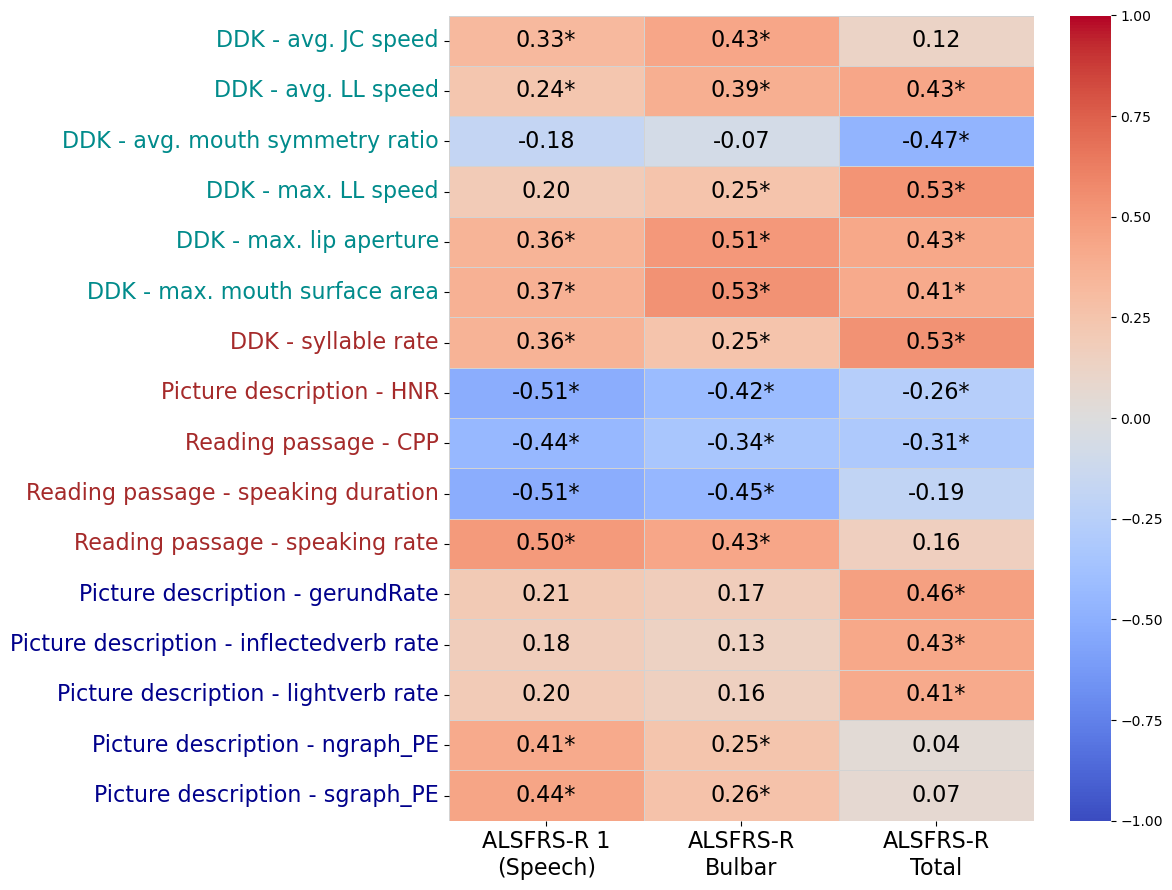

In [5]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
from scipy.stats import spearmanr # Using Spearman
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import sys
import os
import json # Added for JSON loading
from collections import defaultdict # Added for reverse mapping

# --- Suppress warnings ---
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)

# --- Configuration ---
# Output Directory
OUTPUT_DIR = "."
if not os.path.exists(OUTPUT_DIR): os.makedirs(OUTPUT_DIR)
print(f"Using output directory: {OUTPUT_DIR}")

# Input Files
PATH_MAIN_DATA = 'data_preprocessed_linguistic_features_filtered_metrics.csv'
PATH_TRANSLATION_JSON = 'metric_and_task_names_to_display.json'

print(f"Using main data (Facial, Speech, ADL, ALSFRS): '{PATH_MAIN_DATA}'")
print(f"Using translation dictionary: '{PATH_TRANSLATION_JSON}'")

COHORT_COL = 'demo_patient_flag' # From demographics data

# Define ALSFRS-R column names
ALSFRSR_Q1_COL = 'survey_response_scores_ALSFRSR_1'
ALSFRSR_Q2_COL = 'survey_response_scores_ALSFRSR_2'
ALSFRSR_Q3_COL = 'survey_response_scores_ALSFRSR_3'
ALSFRSR_Q4_COL = 'survey_response_scores_ALSFRSR_4'
ALSFRSR_Q5_1_COL = 'survey_response_scores_ALSFRSR_5_1'
ALSFRSR_Q6_COL = 'survey_response_scores_ALSFRSR_6'
ALSFRSR_Q7_COL = 'survey_response_scores_ALSFRSR_7'
ALSFRSR_Q8_COL = 'survey_response_scores_ALSFRSR_8'
ALSFRSR_Q9_COL = 'survey_response_scores_ALSFRSR_9'
ALSFRSR_Q10_COL = 'survey_response_scores_ALSFRSR_10'
ALSFRSR_Q11_COL = 'survey_response_scores_ALSFRSR_11'
ALSFRSR_Q12_COL = 'survey_response_scores_ALSFRSR_12'
ALSFRSR_BULBAR_COL_NAME = 'ALSFRS-R Bulbar' # Consistent naming
ALSFRSR_TOTAL_COL_NAME = 'ALSFRS-R Total' # Consistent naming

ALL_ALSFRSR_COLS_TO_LOAD = [
    ALSFRSR_Q1_COL, ALSFRSR_Q2_COL, ALSFRSR_Q3_COL, ALSFRSR_Q4_COL,
    ALSFRSR_Q5_1_COL, ALSFRSR_Q6_COL, ALSFRSR_Q7_COL,
    ALSFRSR_Q8_COL, ALSFRSR_Q9_COL, ALSFRSR_Q10_COL, ALSFRSR_Q11_COL, ALSFRSR_Q12_COL
]
ALSFRSR_TARGET_COLS = [ # Targets for correlation
    ALSFRSR_Q1_COL, ALSFRSR_BULBAR_COL_NAME, ALSFRSR_TOTAL_COL_NAME
    #ALSFRSR_Q5_1_COL, ALSFRSR_Q6_COL, ALSFRSR_Q7_COL
]
ALSFRSR_LABEL_MAP = { # Labels for heatmap columns
    ALSFRSR_Q1_COL: 'ALSFRS-R 1\n(Speech)',
    ALSFRSR_BULBAR_COL_NAME: 'ALSFRS-R\nBulbar',
    ALSFRSR_TOTAL_COL_NAME: 'ALSFRS-R\nTotal',
#    ALSFRSR_Q5_1_COL: 'ALSFRS-R 5.1 (Cut Food)',
#    ALSFRSR_Q6_COL: 'ALSFRS-R 6 (Dress/Hyg)',
#    ALSFRSR_Q7_COL: 'ALSFRS-R 7 (Turn Bed)'
}

# --- Define prefixes for ALL feature types ---
FACIAL_PREFIX = 'facial_metrics_'
SPEECH_PREFIX = 'speech_metrics_'
LINGUISTIC_PREFIX = 'text_metrics_'
ADL_PREFIX = 'ADL' # Corrected prefix based on CSV header inspection

# --- Mapping from feature group name to prefix ---
# Used to add prefix column during aggregation
PREFIX_MAP = {
    "Facial": FACIAL_PREFIX,
    "Speech": SPEECH_PREFIX,
    "Linguistic": LINGUISTIC_PREFIX,
    "ADL": ADL_PREFIX
}

# --- Font colors for Y-AXIS heatmap labels ---  (Updated Purpose)
# Adjusted to match the actual prefixes used in the code
YAXIS_LABEL_COLORS = { # Renamed for clarity
    SPEECH_PREFIX: 'brown',
    FACIAL_PREFIX: 'darkcyan',
    LINGUISTIC_PREFIX: 'darkblue',
    ADL_PREFIX: 'black'
    # No cognitive metrics prefix defined, so removed from here
}
DEFAULT_YAXIS_COLOR = 'grey' # Color for labels whose group is unknown or mixed

# Heatmap Style Configuration
HEATMAP_CMAP = 'coolwarm'
HEATMAP_ANNOT_FMT = ".2f"
HEATMAP_CENTER = 0.0
SIGNIFICANCE_THRESHOLD = 0.05
MIN_PAIRS_THRESHOLD = 5 # Min pairs for pairwise correlation
ANNOTATION_COLOR = 'black' # --- NEW: Set annotation color to black ---

# --- Load Translation Dictionary ---
print(f"\nLoading translation dictionary from {PATH_TRANSLATION_JSON}...")
try:
    with open(PATH_TRANSLATION_JSON, 'r', encoding='utf-8') as f:
        translation_dict = json.load(f)
    print("Translation dictionary loaded successfully.")
    reverse_translation_map = defaultdict(list)
    # This map will be populated after data loading
except FileNotFoundError:
    print(f"Error: Translation file not found at '{PATH_TRANSLATION_JSON}'. Translations will not be applied.")
    translation_dict = {}
    reverse_translation_map = defaultdict(list)
except json.JSONDecodeError:
    print(f"Error: Could not decode JSON from '{PATH_TRANSLATION_JSON}'. Translations might be incorrect.")
    translation_dict = {}
    reverse_translation_map = defaultdict(list)
except Exception as e:
    print(f"An unexpected error occurred loading the translation file: {e}")
    translation_dict = {}
    reverse_translation_map = defaultdict(list)

# --- Functions ---

def clean_col_names(df):
    """Strips leading/trailing whitespace from DataFrame column names."""
    df.columns = df.columns.str.strip()
    return df

def clean_feature_list(df, cols):
    """Checks if columns exist and have any valid numeric data."""
    valid_cols = []
    for col in cols:
        if col in df.columns:
            numeric_series = pd.to_numeric(df[col], errors='coerce')
            if numeric_series.notna().any():
                valid_cols.append(col)
    return valid_cols

def calculate_correlations_pairwise_spearman(df, feature_cols, target_cols, min_pairs=3):
    """
    Calculates Spearman correlations (rho and p-value) using pairwise deletion.
    """
    results = []
    skipped_metrics_count = 0
    valid_pairs_calculated = 0

    for feature in feature_cols:
        if feature not in df.columns: continue
        feature_has_data = False

        for target in target_cols:
            if target not in df.columns: continue
            pair_data = df[[feature, target]].dropna() # Pairwise deletion

            if len(pair_data) < min_pairs: continue
            if pair_data[feature].nunique(dropna=True) < 2 or pair_data[target].nunique(dropna=True) < 2: continue

            try:
                corr, p_value = spearmanr(pair_data[feature], pair_data[target])
                if not np.isnan(corr) and not np.isnan(p_value):
                    results.append({
                        'Feature': feature,
                        'Target': target,
                        'Correlation (rho)': corr,
                        'P-value': p_value,
                        'N_pairs': len(pair_data)
                    })
                    feature_has_data = True
                    valid_pairs_calculated += 1
            except ValueError as ve:
                pass

        if not feature_has_data:
             skipped_metrics_count += 1

    if skipped_metrics_count > 0:
        print(f"Note: {skipped_metrics_count} metrics had insufficient data pairs (<{min_pairs}) or constant values for Spearman correlation with any target and were skipped.")

    print(f"Total valid Spearman correlation pairs calculated: {valid_pairs_calculated}")
    return pd.DataFrame(results)

def translate_label(text, conversion_dict):
    """Replaces parts of a label based on a key-value dictionary."""
    if not text:
        return text
    translated = text
    for key, value in conversion_dict.items():
        translated = translated.replace(key, value)
    return translated

# --- UPDATED AGGREGATED PLOTTING FUNCTION ---
def plot_aggregated_correlation_heatmap(
    combined_results_df,
    target_label_map,
    translation_dict,
    yaxis_label_colors, # Changed name
    orig_feature_to_prefix_map,
    reverse_translation_map_local, # Pass this specific map
    p_threshold=0.05
):
    """
    Generates ONE aggregated heatmap. Annotations are black.
    Y-axis labels are colored based on the original feature group.
    """
    if combined_results_df is None or combined_results_df.empty:
        print(f"\nNo correlation results found for any group. Skipping aggregated heatmap.")
        return

    print("\n--- Generating Aggregated Heatmap (Black Annotations, Colored Y-Labels) ---")

    # Filter for features with AT LEAST ONE significant correlation across ALL groups
    significant_results = combined_results_df[(combined_results_df['P-value'] < p_threshold) & (combined_results_df['Correlation (rho)'].abs() >= 0.4)].copy()
    if significant_results.empty:
        print(f"\nNo significant Spearman correlations (p < {p_threshold}) found across all features. Skipping aggregated heatmap.")
        return

    significant_features = significant_results['Feature'].unique()
    print(f"\nFound {len(significant_features)} features across all groups with >= 1 significant Spearman correlation (p < {p_threshold}).")

    # Filter original combined results to only include these significant features (vs all targets)
    heatmap_data_filtered = combined_results_df[combined_results_df['Feature'].isin(significant_features)]

    # Add Translated Feature column
    heatmap_data_filtered['Translated Feature'] = heatmap_data_filtered['Feature'].map(
        lambda orig: translate_label(orig, translation_dict)
    )

    # Pivot for heatmap - Correlation Values (rho) - Use Translated Feature for index
    try:
        heatmap_pivot = heatmap_data_filtered.pivot_table(index='Translated Feature', columns='Target', values='Correlation (rho)', aggfunc='mean')
        heatmap_pivot = heatmap_pivot.reindex(columns=list(target_label_map.keys())) # Ensure target order
    except Exception as e:
        print(f"Error creating aggregated correlation pivot table: {e}. Skipping heatmap.")
        return

    # Pivot for heatmap - P-Values - Use Translated Feature for index
    try:
        pval_pivot = heatmap_data_filtered.pivot_table(index='Translated Feature', columns='Target', values='P-value', aggfunc='min')
        pval_pivot = pval_pivot.reindex(index=heatmap_pivot.index, columns=heatmap_pivot.columns)
    except Exception as e:
        print(f"Error creating aggregated p-value pivot table: {e}. Significance asterisks may be missing.")
        pval_pivot = pd.DataFrame(np.nan, index=heatmap_pivot.index, columns=heatmap_pivot.columns)

    # Apply labels to columns (Targets)
    heatmap_pivot.columns = [target_label_map.get(col, col) for col in heatmap_pivot.columns]
    pval_pivot.columns = [target_label_map.get(col, col) for col in pval_pivot.columns]

    # Sort index alphabetically (using translated labels)
    heatmap_pivot.sort_index(inplace=True)
    if not pval_pivot.empty:
        pval_pivot = pval_pivot.reindex(index=heatmap_pivot.index, columns=heatmap_pivot.columns)
    else:
        pval_pivot = pd.DataFrame(np.nan, index=heatmap_pivot.index, columns=heatmap_pivot.columns)

    # --- Create Annotation Labels with Asterisks (as strings) ---
    is_significant = pval_pivot < p_threshold
    rho_strings = heatmap_pivot.applymap(lambda x: f'{x:{HEATMAP_ANNOT_FMT}}' if pd.notna(x) else '')
    sig_strings = is_significant.applymap(lambda x: '*' if x else '')

    try:
        rho_strings_aligned, sig_strings_aligned = rho_strings.align(sig_strings, join='inner', axis=None, fill_value='')
        annot_labels_df = rho_strings_aligned + sig_strings_aligned
        if heatmap_pivot.shape != annot_labels_df.shape:
             raise ValueError("Shape mismatch after alignment")
    except Exception as e:
        print(f"\\n!!! Error aligning or combining annotations: {e} !!!")
        print(" Using correlation values only for annotations.")
        annot_labels_df = rho_strings

    # Final Shape Check before plotting
    if heatmap_pivot.shape != annot_labels_df.shape:
        print(f"\\n!!! CRITICAL ERROR: Shape mismatch before heatmap !!!")
        print(f"Skipping aggregated heatmap due to shape mismatch.")
        return

    FONT_SIZE = 16
    # Determine figure size
    num_features = len(heatmap_pivot.index)
    num_targets = len(heatmap_pivot.columns)
    fig_height = max(10, num_features * 0.35)
    fig_width = max(12, num_targets * 1.8)

    # Create figure and plot heatmap (WITH default annotations now, color controlled by annot_kws)
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    sns.heatmap(
        heatmap_pivot,
        ax=ax,
        annot=annot_labels_df, # Provide the combined labels DataFrame/array
        fmt='', # Already formatted in annot_labels_df
        cmap=HEATMAP_CMAP,
        center=HEATMAP_CENTER,
        linewidths=.5,
        linecolor='lightgray',
        cbar=True,
        #cbar_kws={'label': 'Spearman Correlation Coefficient (ρ)', 'shrink': 0.7},
        vmin=-1, vmax=1,
        annot_kws={"size": FONT_SIZE, "color": ANNOTATION_COLOR} # --- Set annotation color here ---
    )
    #ax.set_title(f'Aggregated Significant Spearman Correlations (p < {p_threshold})\nAll Features vs. ALSFRS-R Scores (Pairwise Deletion)', fontsize=14, pad=20)
    #ax.set_xlabel('ALSFRS-R Scores', fontsize=16)
    #ax.set_ylabel(f'Significant Features (Translated)', fontsize=16)
    ax.set_ylabel('')

    # Apply X tick parameters and alignment
    ax.tick_params(axis='x', labelsize=FONT_SIZE, rotation=0)
    #plt.setp(ax.get_xticklabels(), ha='right', rotation_mode='anchor')
    # Adjust Y tick size (color applied below)
    ax.tick_params(axis='y', rotation=0, labelsize=FONT_SIZE)

    # --- Color Y-axis Tick Labels ---
    print("Coloring Y-axis labels...")
    colored_labels = 0
    default_colored_labels = 0
    for tick_label in ax.get_yticklabels():
        label_text = tick_label.get_text()
        color = DEFAULT_YAXIS_COLOR # Default

        original_features = reverse_translation_map_local.get(label_text, [])
        if original_features:
            # Use prefix from the first original feature found
            orig_feature = original_features[0]
            prefix = orig_feature_to_prefix_map.get(orig_feature)
            if prefix and prefix in yaxis_label_colors:
                color = yaxis_label_colors[prefix]
                colored_labels += 1
            else:
                default_colored_labels += 1
                # Optional: warning if prefix/color missing for a known feature
                # print(f"Warning: No color defined for prefix '{prefix}' (Label: '{label_text}')")
        else:
            default_colored_labels += 1
            # Optional: warning if label has no reverse mapping
            # print(f"Warning: Cannot find original feature for Y-axis label '{label_text}'")

        tick_label.set_color(color)
    ylabels = [item.get_text() for item in ax.get_yticklabels()]
    ylabels = [re.sub('text_metrics_', '', x) for x in ylabels]
    ylabels = [re.sub('facial_metrics_', '', x) for x in ylabels]
    ylabels = [re.sub('speech_metrics_', '', x) for x in ylabels]
    ax.set_yticklabels(ylabels)

    print(f"Colored {colored_labels} Y-axis labels based on group. {default_colored_labels} used default color.")

    plt.tight_layout(rect=[0, 0.05, 1, 0.95])

    # Save figure
    output_filename_base = 'spearman_correlation_heatmap_AGGREGATED_black_annot_color_y.png'
    output_filename = os.path.join(OUTPUT_DIR, output_filename_base)
    try:
        fig.savefig(output_filename, dpi=300, bbox_inches='tight')
        print(f"Aggregated heatmap saved to: {output_filename}")
    except Exception as e:
        print(f"Error saving aggregated heatmap: {e}")
    # plt.close(fig)


# --- Load Data ---
print("\nLoading data...")
try:
    df_main = pd.read_csv(PATH_MAIN_DATA, low_memory=False)
    print(f"Loaded main data. Shape: {df_main.shape}")
except FileNotFoundError as e:
    print(f"Error loading file: {e}. Please ensure paths are correct.")
    sys.exit(1)
except Exception as e:
    print(f"An error occurred loading data: {e}")
    sys.exit(1)

# Clean column names once after loading
df_main = clean_col_names(df_main)

# --- Filter for Patients ---
print("\nFiltering for patient sessions...")
if COHORT_COL in df_main.columns:
    df_processed = df_main[df_main[COHORT_COL]==1].copy()
    print(f"Filtered down to {df_processed.shape[0]} patient sessions.")
else:
    print(f"Error: Cohort column '{COHORT_COL}' not found in the data. Cannot filter for patients.")
    sys.exit(1)

if df_processed.empty:
    print("Error: No patient data found after filtering. Cannot proceed.")
    sys.exit(1)

# --- Identify ALL Feature Columns from respective sources ---
print("\nIdentifying all feature column sets from filtered patient data...")
all_columns = df_processed.columns
facial_cols = [col for col in all_columns if col.startswith(FACIAL_PREFIX) and not col.endswith(('_px', '_mm'))]
speech_cols = [col for col in all_columns if col.startswith(SPEECH_PREFIX)]
linguistic_cols = [col for col in all_columns if col.startswith(LINGUISTIC_PREFIX)]
adl_cols = [col for col in all_columns if col.startswith(ADL_PREFIX)]

# Validate feature lists
facial_cols = clean_feature_list(df_processed, facial_cols)
speech_cols = clean_feature_list(df_processed, speech_cols)
linguistic_cols = clean_feature_list(df_processed, linguistic_cols)
adl_cols = clean_feature_list(df_processed, adl_cols)

# Combine all identified valid metric columns for later mapping and reverse translation
all_metric_cols_identified = facial_cols + speech_cols + linguistic_cols + adl_cols
# Populate reverse translation map based on actual columns
print("Populating reverse translation map...")
for orig_col in all_metric_cols_identified:
    translated = translate_label(orig_col, translation_dict)
    reverse_translation_map[translated].append(orig_col)
print(f"Reverse translation map populated with {len(reverse_translation_map)} entries.")


feature_sets = {
    "Facial": facial_cols,
    "Speech": speech_cols,
    "Linguistic": linguistic_cols,
#    "ADL": adl_cols
}
print(f"Validated {len(facial_cols)} facial feature columns.")
print(f"Validated {len(speech_cols)} speech feature columns.")
print(f"Validated {len(linguistic_cols)} linguistic feature columns.")
print(f"Validated {len(adl_cols)} ADL feature columns.")

# --- Data Preparation (Numeric Conversion, Bulbar Score on df_processed) ---
print("\nPreparing final patient data for correlation...")
all_metric_cols = facial_cols + speech_cols + linguistic_cols + adl_cols
alsfrs_cols_present = [col for col in ALL_ALSFRSR_COLS_TO_LOAD if col in df_processed.columns]
all_cols_to_convert = alsfrs_cols_present + all_metric_cols

print(f"Ensuring columns are numeric (if not already)...")
cols_converted_count = 0
cols_already_numeric = 0
for col in all_cols_to_convert:
    if col in df_processed.columns:
        if pd.api.types.is_numeric_dtype(df_processed[col]):
             cols_already_numeric += 1
        else:
             df_processed[col] = pd.to_numeric(df_processed[col], errors='coerce')
             cols_converted_count += 1
print(f" {cols_converted_count} columns converted to numeric (errors='coerce'). {cols_already_numeric} already numeric.")


# Calculate ALSFRS-R Bulbar Score
print("Calculating ALSFRS-R Bulbar score...")
bulbar_input_cols_present = [col for col in [ALSFRSR_Q1_COL, ALSFRSR_Q2_COL, ALSFRSR_Q3_COL] if col in df_processed.columns]
if len(bulbar_input_cols_present) == 3:
    for col in bulbar_input_cols_present:
        if not pd.api.types.is_numeric_dtype(df_processed[col]):
             df_processed[col] = pd.to_numeric(df_processed[col], errors='coerce')
    df_processed[ALSFRSR_BULBAR_COL_NAME] = df_processed[bulbar_input_cols_present].sum(axis=1, skipna=False)
    df_processed[ALSFRSR_BULBAR_COL_NAME] = pd.to_numeric(df_processed[ALSFRSR_BULBAR_COL_NAME], errors='coerce')
    print(f"Calculated '{ALSFRSR_BULBAR_COL_NAME}'.")
else:
    missing_bulbar = set([ALSFRSR_Q1_COL, ALSFRSR_Q2_COL, ALSFRSR_Q3_COL]) - set(bulbar_input_cols_present)
    print(f"Warning: Could not calculate '{ALSFRSR_BULBAR_COL_NAME}'. Missing input columns: {missing_bulbar}")
    if ALSFRSR_BULBAR_COL_NAME not in df_processed.columns:
        df_processed[ALSFRSR_BULBAR_COL_NAME] = np.nan

# ALSFRS-R Total Score
df_processed[ALSFRSR_TOTAL_COL_NAME] = df_processed[ALL_ALSFRSR_COLS_TO_LOAD].sum(axis=1, min_count=12, skipna=False)

# --- Correlation Calculation & Aggregation ---
print("\n--- Starting Spearman Correlation Analysis (Pairwise Deletion) vs. ALSFRS-R Scores ---")
all_results_list = []
orig_feature_to_prefix_map = {}

for name, metric_cols in feature_sets.items():
    if not metric_cols:
        print(f"\nSkipping {name} features (no valid columns found).")
        continue

    print(f"\n>>> Processing Group: {name} <<<\n")

    current_alsfrs_targets = [col for col in ALSFRSR_TARGET_COLS if col in df_processed.columns and df_processed[col].notna().any()]
    if not current_alsfrs_targets:
        print(f"Warning: No valid ALSFRS-R target columns found or all targets are NaN for {name}. Skipping.")
        continue
    print(f"Using {len(metric_cols)} {name} metrics vs {len(current_alsfrs_targets)} ALSFRS-R targets.")

    results_df = calculate_correlations_pairwise_spearman(
        df_processed, metric_cols, current_alsfrs_targets, min_pairs=MIN_PAIRS_THRESHOLD
    )

    if not results_df.empty:
        group_prefix = PREFIX_MAP.get(name)
        if group_prefix:
            results_df['Feature Group Prefix'] = group_prefix
            for feature in results_df['Feature'].unique():
                 if feature not in orig_feature_to_prefix_map:
                      orig_feature_to_prefix_map[feature] = group_prefix
            all_results_list.append(results_df)
        else:
            print(f"Warning: No prefix defined in PREFIX_MAP for group '{name}'. Results not added to aggregation.")
    else:
         print(f"No valid Spearman correlations met the threshold ({MIN_PAIRS_THRESHOLD} pairs) for {name} features.")

# --- Combine Results and Plot Aggregated Heatmap ---
if all_results_list:
    combined_results_df = pd.concat(all_results_list, ignore_index=True)
    print(f"\nCombined {combined_results_df.shape[0]} correlation pairs from all groups.")

    # Generate the single, aggregated heatmap
    plot_aggregated_correlation_heatmap(
        combined_results_df,
        ALSFRSR_LABEL_MAP,
        translation_dict,
        YAXIS_LABEL_COLORS, # Pass renamed dict
        orig_feature_to_prefix_map,
        reverse_translation_map, # Pass the populated global reverse map
        p_threshold=SIGNIFICANCE_THRESHOLD
    )
else:
    print("\nNo correlation results found for any feature group. Cannot generate aggregated heatmap.")


print("\nAnalysis complete. Displaying plots (if any generated)...")
plt.show()
